# Using 2657 tournament matches of Hikaru Nakamura to train a chess engine
This notebook trains a deep neural network with 2657 tournament matches of the top player H. Nakamura to play chess.

In [184]:
import chess.pgn
import torch
import numpy as np
import os, os.path
import timeit

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from adabelief_pytorch import AdaBelief

device = torch.device("cuda")

## Loading the games

In [172]:
# loading the games
DIR = 'data/Raw_game/Raw_game/Nakamura/'
games = []
numberOfGames = 0
start = timeit.default_timer()
for name in os.listdir(DIR):
    numberOfGames += 1
    games.append(chess.pgn.read_game(open(DIR+name)))
stop = timeit.default_timer()
print("Loaded", numberOfGames, "games in", stop - start, "seconds.")

Loaded 2657 games in 8.175487308999436 seconds.


In [205]:
def boardToTensor(board):
    boardArray = np.array([a.split(" ") for a in str(board).split("\n")])
    
    wPMask = np.array([boardArray == "P"], dtype=np.int)
    bPMask = np.array([boardArray == "p"], dtype=np.int)
    wBMask = np.array([boardArray == "B"], dtype=np.int)
    bBMask = np.array([boardArray == "b"], dtype=np.int)
    wNMask = np.array([boardArray == "N"], dtype=np.int)
    bNMask = np.array([boardArray == "n"], dtype=np.int)
    wRMask = np.array([boardArray == "R"], dtype=np.int)
    bRMask = np.array([boardArray == "r"], dtype=np.int)
    wQMask = np.array([boardArray == "Q"], dtype=np.int)
    bQMask = np.array([boardArray == "q"], dtype=np.int)
    wKMask = np.array([boardArray == "K"], dtype=np.int)
    bKMask = np.array([boardArray == "k"], dtype=np.int)
    tensor = np.zeros((6,8,8))
    
    tensor[0] = wPMask - bPMask
    tensor[1] = wBMask - bBMask
    tensor[2] = wNMask - bNMask
    tensor[3] = wRMask - bRMask
    tensor[4] = wQMask - bQMask
    tensor[5] = wKMask - bKMask
    
    return torch.FloatTensor(tensor).view(1,6,8,8)

In [341]:
def moveToTensor(move):
    boardLetters = "abcdefgh"
    moveArray = list(str(move))[:4]
    tensor = np.zeros((4,4,4))
    for i, l in enumerate(moveArray):
        tmp = np.zeros((16))
        if i%2 == 0:
            index = boardLetters.find(l)
            tmp[index] = 1
        else:
            index = int(l)-1
            tmp[index] = 1
        tensor[i] = tmp.reshape((4,4))
    return torch.FloatTensor(tensor)

## Datastructure

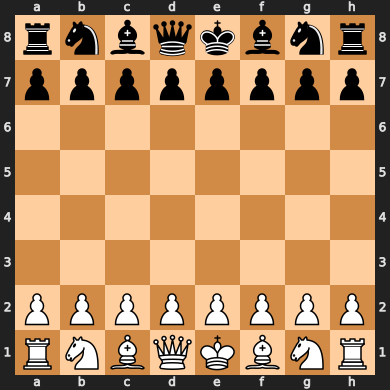

In [452]:
games[0].board()

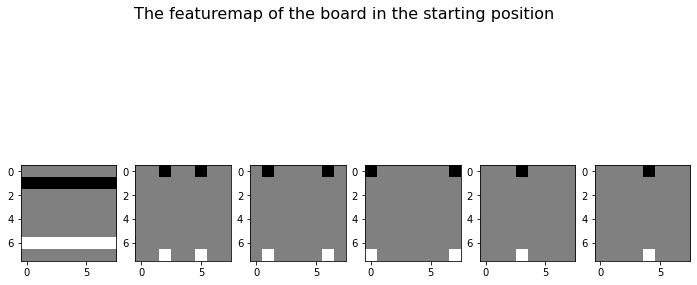

In [428]:
boardMap = boardToTensor(games[0].board())[0]
fig = plt.figure(figsize=(12,6))
figNo = 1
fig.suptitle("The featuremap of the board in the starting position",fontsize=16)
for i in range(6):
    fig.add_subplot(1,6, figNo)
    plt.imshow(boardMap[i], cmap="gray")
    figNo += 1
plt.show()

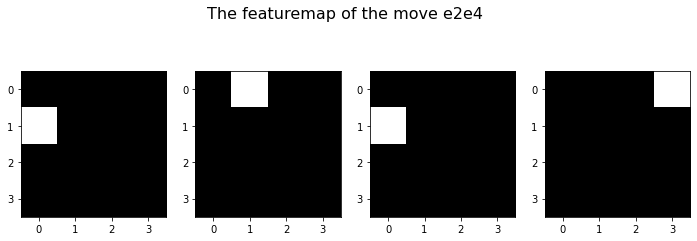

In [429]:
moveMap = moveToTensor(list(games[0].mainline_moves())[0])
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(moveMap[i], cmap="gray")
    figNo += 1
fig.suptitle("The featuremap of the move e2e4",fontsize=16)
plt.show()

In [434]:
X, Y = [], []
for i in range(30):
    if games[i].headers["White"] == "Nakamura, Hi":
        turn = 1
    else:
        turn = 2
    board = games[i].board()
    for move in games[i].mainline_moves():
        turn += 1
        board.push(move)
        if turn % 2 == 0:
            #print(str(move))
            Y.append(moveToTensor(move).to(device))
        else:
            X.append(boardToTensor(board).to(device))

## Model

In [435]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(6, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = torch.nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = torch.nn.Conv2d(32, 4, kernel_size = 3, stride = 1, padding = 1)
        
        self.pool = torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (1,1))
        x = F.max_pool2d(F.relu(self.conv2(x)), (1,1))
        x = F.max_pool2d(F.relu(self.conv3(x)), (1,1))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2,2))
        
        return torch.tanh(x)

In [449]:
model = Net().to(device)
#optimizer = AdaBelief(model.parameters(), lr=1e-3, eps=1e-16, betas=(0.9,0.999), weight_decouple = True, rectify = False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

In [450]:
print(model)

Net(
  (conv1): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
for i in range(100):
    j=0
    for x, y in zip(X,Y):
        optimizer.zero_grad()
        
        y_pred = model(x)
        #print(y_pred, y)
        single_loss = loss_function(y_pred, y)
        single_loss.backward()
        optimizer.step()
        print(f"Epoch: {i}. Loss: {single_loss.item()}", end="\r")
        j += 1
    writer.add_scalar('Loss/train', single_loss.item(), i)

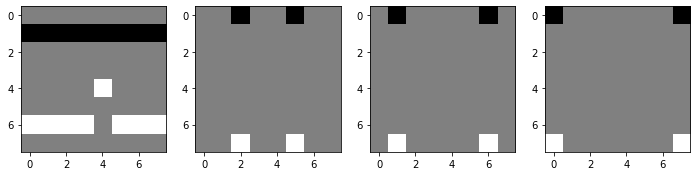

In [439]:
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(X[0][0].cpu()[i], cmap="gray")
    figNo += 1
plt.show()

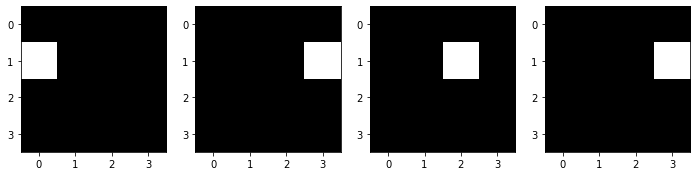

In [448]:
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(Y[8].cpu()[i], cmap="gray")
    figNo += 1
plt.show()

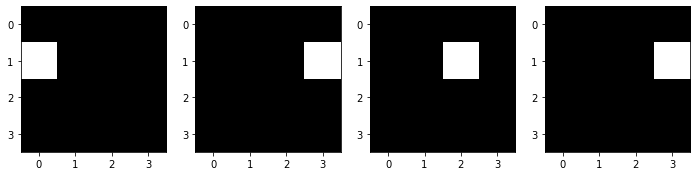

In [447]:
output = model(X[8]).cpu().detach().numpy()
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(4):
    fig.add_subplot(1,4, figNo)
    plt.imshow(output[0][i], cmap="gray")
    figNo += 1
plt.show()